## 1. 환경 설정

`(1) Env 환경변수`

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

`(2) 기본 라이브러리`

In [2]:
import re
import os, json

from textwrap import dedent
from pprint import pprint

import warnings
warnings.filterwarnings("ignore")

## 2. State Reducer
- Reducer는 LangGraph에서 상태 업데이트를 관리하는 중요한 개념
- 그래프의 각 노드의 출력을 그래프의 상태에 통합하는 방법을 정의
- Reducer의 필요성
    - 상태 덮어쓰기 문제: 기본적으로 각 노드의 반환값은 해당 상태 키의 이전 값을 덮어쓰는 방식으로 동작 (override)
    - 누적 업데이트 필요: 특히 메시지 리스트와 같은 경우, 이전 상태에 새로운 값을 추가하고 싶을 때가 있음 

`(1) Reducer를 별도로 지정하지 않은 경우 `
- reducer를 별도로 지정하지 않은 경우 기존 값을 덮어쓰는 방식으로 동작
- 기본 reducer는 상태에 대해 별도의 설정 없이 사용될 때 자동으로 적용

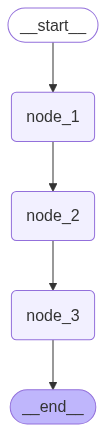

In [3]:
from typing import TypedDict, List
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# 상태 정의 
class DocumentState(TypedDict):
    query: str
    documents: List[str]

# Node 1: query 업데이트
def node_1(state: DocumentState) -> DocumentState:
    print("---Node 1 (query update)---")
    query = state["query"]
    return {"query": query}

# Node 2: 검색된 문서 추가 
def node_2(state: DocumentState) -> DocumentState:
    print("---Node 2 (add documents)---")
    return {"documents": ["doc1.pdf", "doc2.pdf", "doc3.pdf"]}

# Node 3: 추가적인 문서 검색 결과 추가
def node_3(state: DocumentState) -> DocumentState:
    print("---Node 3 (add more documents)---")
    return {"documents": ["doc3.pdf", "doc4.pdf", "doc5.pdf"]}


# 그래프 빌드
builder = StateGraph(DocumentState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# 논리 구성
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", "node_3")
builder.add_edge("node_3", END)

# 그래프 실행
graph = builder.compile()

# 그래프 시각화
display(Image(graph.get_graph().draw_mermaid_png()))


In [4]:
# 초기 상태
initial_state = {"query": "채식주의자를 위한 비건 음식을 추천해주세요."}

# 그래프 실행 
final_state = graph.invoke(initial_state)

# 최종 상태 출력
print("최종 상태:", final_state)

---Node 1 (query update)---
---Node 2 (add documents)---
---Node 3 (add more documents)---
최종 상태: {'query': '채식주의자를 위한 비건 음식을 추천해주세요.', 'documents': ['doc3.pdf', 'doc4.pdf', 'doc5.pdf']}


`(2) Reducer를 별도로 지정하는 경우 `
- `Annotated` 사용하여 지정한 reducer 작동 방식에 따라 기존 상태 정보를 업데이트 
- 리스트를 병합하는 `operator.add`를 사용하면, activity_log를 누적하는 방식으로 노드를 구현

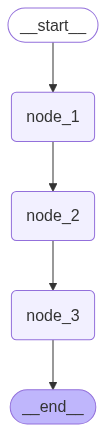

In [5]:
from operator import add
from typing import Annotated, TypedDict

class ReducerState(TypedDict):
    query: str
    #documents: List[str]
    documents: Annotated[List[str], add]

# Node 1: query 업데이트
def node_1(state: ReducerState) -> ReducerState:
    print("---Node 1 (query update)---")
    query = state["query"]
    return {"query": query}

# Node 2: 검색된 문서 추가 
def node_2(state: ReducerState) -> ReducerState:
    print("---Node 2 (add documents)---")
    return {"documents": ["doc1.pdf", "doc2.pdf", "doc3.pdf"]}

# Node 3: 추가적인 문서 검색 결과 추가
def node_3(state: ReducerState) -> ReducerState:
    print("---Node 3 (add more documents)---")
    return {"documents": ["doc2.pdf", "doc4.pdf", "doc5.pdf"]}

# 그래프 빌드
builder = StateGraph(ReducerState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# 논리 구성
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", "node_3")
builder.add_edge("node_3", END)

# 그래프 실행
graph = builder.compile()

# 그래프 시각화
display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
# 초기 상태
initial_state = {"query": "채식주의자를 위한 비건 음식을 추천해주세요."}

# 그래프 실행 
final_state = graph.invoke(initial_state)

# 최종 상태 출력
print("최종 상태:", final_state)

---Node 1 (query update)---
---Node 2 (add documents)---
---Node 3 (add more documents)---
최종 상태: {'query': '채식주의자를 위한 비건 음식을 추천해주세요.', 'documents': ['doc1.pdf', 'doc2.pdf', 'doc3.pdf', 'doc2.pdf', 'doc4.pdf', 'doc5.pdf']}


`(3) Custom Reducer 사용 `
- 상태 업데이트가 기본적인 덮어쓰기나 병합만으로 해결되지 않을 때 유용한 방법
- 중복 제거, 최대/최소 값 유지, 조건부 병합 등의 특정 비즈니스 로직이 필요한 경우에 적용

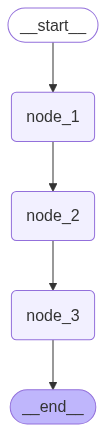

In [7]:
from typing import TypedDict, List, Annotated

# Custom reducer: 중복된 문서를 제거하며 리스트 병합
def reduce_unique_documents(left: list | None, right: list | None) -> list:
    """Combine two lists of documents, removing duplicates."""
    if not left:
        left = []
    if not right:
        right = []
    # 중복 제거: set을 사용하여 중복된 문서를 제거하고 다시 list로 변환
    return list(set(left + right))

# 상태 정의 (documents 필드 포함)
class CustomReducerState(TypedDict):
    query: str
    documents: Annotated[List[str], reduce_unique_documents]  # Custom Reducer 적용


# Node 1: query 업데이트
def node_1(state: CustomReducerState) -> CustomReducerState:
    print("---Node 1 (query update)---")
    query = state["query"]
    return {"query": query}

# Node 2: 검색된 문서 추가 
def node_2(state: CustomReducerState) -> CustomReducerState:
    print("---Node 2 (add documents)---")
    return {"documents": ["doc1.pdf", "doc2.pdf", "doc3.pdf"]}

# Node 3: 추가적인 문서 검색 결과 추가
def node_3(state: CustomReducerState) -> CustomReducerState:
    print("---Node 3 (add more documents)---")
    return {"documents": ["doc2.pdf", "doc4.pdf", "doc5.pdf"]}

# 그래프 빌드
builder = StateGraph(CustomReducerState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# 논리 구성
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", "node_3")
builder.add_edge("node_3", END)

# 그래프 실행
graph = builder.compile()

# 그래프 시각화
display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
# 초기 상태
initial_state = {"query": "채식주의자를 위한 비건 음식을 추천해주세요.", "documents": []}

# 그래프 실행 
final_state = graph.invoke(initial_state)

# 최종 상태 출력
print("최종 상태:", final_state)

---Node 1 (query update)---
---Node 2 (add documents)---
---Node 3 (add more documents)---
최종 상태: {'query': '채식주의자를 위한 비건 음식을 추천해주세요.', 'documents': ['doc3.pdf', 'doc2.pdf', 'doc1.pdf', 'doc4.pdf', 'doc5.pdf']}


## 3. MessageGraph
- LangChain의 ChatModel은 Message 객체 목록을 입력으로 처리 (StateGraph의 특수한 유형)
- 이러한 메시지들은 HumanMessage(사용자 입력)나 AIMessage(LLM 응답) 등 다양한 형태로 제공

`(1) Messages State 정의`
- 이전 대화 기록을 그래프 상태에 메시지 목록으로 저장하는 것이 유용
- 그래프 상태에 Message 객체 목록을 저장하는 키(채널)를 추가하고, 이 키에 리듀서 함수를 추가 
- 리듀서 함수 선택:
    - operator.add를 사용하면: 새 메시지를 기존 목록에 단순히 추가
    - add_messages 함수를 사용하면:
        - 새 메시지는 기존 목록에 추가
        - 기존 메시지 업데이트도 올바르게 처리 (메시지 ID를 추적)

In [15]:
from typing import Annotated
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

# 기본 State 초기화 방법을 사용
class GraphState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [10]:
# LangGraph MessagesState라는 미리 만들어진 상태를 사용
from langgraph.graph import MessagesState
from typing import List
from langchain_core.documents import Document

'''
class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
'''

class GraphState(MessagesState):
    # messages 키는 기본 제공 - 다른 키를 추가하고 싶을 경우 아래 주석과 같이 적용 가능 
    documents: List[Document]
    grade: float
    num_generation: int

`(2) RAG Chain 구성`
- 메뉴 검색을 위한 벡터저장소를 초기화 (기존 저장소를 로드)
- LangChain Runnable로 구현

In [19]:
from langchain_community.vectorstores import FAISS
from langchain_ollama  import OllamaEmbeddings
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough, RunnableLambda

embeddings_model = OllamaEmbeddings(model="bge-m3:latest") 

# menu db 벡터 저장소 로드
menu_db = FAISS.load_local(
    "./db/menu_db", 
    embeddings_model, 
    allow_dangerous_deserialization=True
)

# LLM 모델 
#llm = ChatOpenAI(model="gpt-4o-mini")
llm = ChatOpenAI(
    #api_key=OPENAI_API_KEY,
    base_url="https://api.groq.com/openai/v1",  # Groq API 엔드포인트
    model="meta-llama/llama-4-scout-17b-16e-instruct",
    temperature=0.7
)

# RAG 체인 구성
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

system = """
You are a helpful assistant. Use the following context to answer the user's question:

[Context]
{context}
"""

prompt = ChatPromptTemplate.from_messages([
    ("system", system),
    ("human", "{question}")
])

# 검색기 정의
retriever = menu_db.as_retriever(
    search_kwargs={"k": 6}
)

# RAG 체인 구성
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

# RAG 체인 실행
query = "채식주의자를 위한 메뉴를 추천해주세요."
response = rag_chain.invoke(query)

# 답변 출력
print(response)

채식주의자를 위한 메뉴는 가든 샐러드와 버섯 크림 수프가 있습니다. 가든 샐러드는 신선한 유기농 채소들로 구성된 건강한 샐러드이며, 버섯 크림 수프는 양송이버섯과 표고버섯을 오랜 시간 정성스레 끓여 만든 크림 수프입니다. 두 메뉴 모두 고기를 포함하지 않아 채식주의자에게 적합합니다.


`(3) 노드(Node)`

In [39]:
'''
initial_state = {
    "messages": [HumanMessage(content=query)],
}
'''
# RAG 수행 함수 정의
def retrieve_and_respond(state: GraphState):
    """
    주어진 상태에서 질문을 추출하고 RAG(Retrieval-Augmented Generation)를 수행하는 함수
    
    Args:
        state (GraphState): 현재 그래프 상태 객체. 다음을 포함:
            - messages: 대화 메시지 리스트 (마지막 메시지는 사용자 질문)
            
    Returns:
        dict: 업데이트된 상태 객체. 다음을 포함:
            - messages: AI 응답 메시지가 추가된 메시지 리스트
            - documents: 검색된 문서 리스트
    """
    
    # 상태에서 마지막 메시지 가져오기 (사용자의 질문)
    # state['messages']는 대화 기록을 저장하는 리스트
    last_human_message = state['messages'][-1]
    
    # HumanMessage 객체에서 실제 질문 내용 추출
    # HumanMessage는 langchain_core.messages에 정의된 사용자 메시지 클래스
    query = last_human_message.content
    
    # 벡터 저장소에서 질문과 관련된 문서 검색
    # retriever는 FAISS 벡터 저장소에서 similarity search를 수행하는 객체
    # search_kwargs={"k": 6}로 설정되어 상위 6개 문서 반환
    retrieved_docs = retriever.invoke(query)
    
    # RAG 체인을 사용하여 응답 생성
    # rag_chain은 다음으로 구성된 체인:
    # 1. 검색된 문서를 context로 변환
    # 2. 사용자 질문과 결합
    # 3. LLM 모델로 전달하여 응답 생성
    # 4. 문자열 파싱
    response = rag_chain.invoke(query)
    
    # 데이트된 상태 반환
    return {
        # 기존 메시지에 AI 응답 메시지 추가
        # AIMessage는 langchain_core.messages에 정의된 AI 응답 메시지 클래스
        "messages": [AIMessage(content=response)],
        # 검색된 문서 저장 (나중에 답변 평가에 사용)
        # documents는 langchain_core.documents.Document 객체 리스트
        "documents": retrieved_docs
    }

#### GradeResponse 모델: 점수(score)와 설명(explanation)을 구조화된 형태로 저장

* score: 0~1 사이 값 (1이 최고점)

* explanation: 점수에 대한 설명

### 평가 프로세스:

* 대화 기록에서 질문과 답변 추출

* 참고 문서를 문자열로 변환

* LLM에게 평가 요청 (질문, 문서, 답변 제공)

* 결과를 구조화된 형식(GradeResponse)으로 수신

### 오류 처리:

* 평가 실패 시 기본 점수(0.5) 반환

* 점수 범위 보정(0 미만 → 0, 1 초과 → 1)

### 상태 업데이트:

* grade: 평가 점수 저장

* num_generation: 답변 생성 횟수 카운팅

* 이 함수는 LangGraph에서 자동 재시도 로직과 연결되어 답변 품질이 낮을 경우 재생성을 트리거합니다.

In [40]:

from pydantic import BaseModel, Field

# 답변 평가 결과를 위한 데이터 모델 정의
class GradeResponse(BaseModel):
    "A score for answers"
    # 점수 (0~1 사이 값, 1이 최고점)
    score: float = Field(
        ...,  # 필수 항목
        ge=0,  # 최소값 0
        le=1,  # 최대값 1 
        description="0에서 1 사이의 점수, 1은 완벽한 답변"
    )
    # 평가 설명
    explanation: str = Field(
        ...,  # 필수 항목
        description="주어진 점수에 대한 설명"
    )
    
# 답변 품질 평가 함수
def grade_answer(state: GraphState):
    """
    AI의 답변을 평가하여 점수를 매기는 함수
    
    Args:
        state (GraphState): 현재 상태 객체
            - messages: 대화 기록 (마지막 두 메시지: [질문, 답변])
            - documents: 참고 문서
            
    Returns:
        dict: 업데이트된 상태
            - grade: 평가 점수 (0~1)
            - num_generation: 답변 생성 횟수
    """
    
    # 대화 기록에서 질문과 답변 추출
    messages = state['messages']
    # 마지막에서 두번째 메시지(사용자 질문)
    question = messages[-2].content
    # 마지막 메시지(AI 답변)
    answer = messages[-1].content
    # 참고 문서를 문자열로 변환
    context = format_docs(state['documents'])
    
    # 평가자 역할을 정의하는 시스템 프롬프트
    grading_system = """
    당신은 전문 평가자입니다.
    주어진 컨텍스트를 고려하여 답변의 정확성과 관련성을 평가하세요.
    0에서 1 사이의 점수(1이 완벽)와 설명을 제공하세요.
    """

    # 평가를 위한 프롬프트 템플릿 생성
    grading_prompt = ChatPromptTemplate.from_messages([
        # 평가자 역할 설정
        ("system", grading_system),
        ("human", 
         "[질문]\n{question}\n\n"    # 사용자 질문
         "[컨텍스트]\n{context}\n\n"  # 참고 문서
         "[답변]\n{answer}\n\n"       # AI 답변
         "[평가]\n")                  # 평가 요청
        #("human", "[Question]\n{question}\n\n[Context]\n{context}\n\n[Answer]\n{answer}\n\n[Grade]\n")
    ])
    
    try:
        # 평가 체인 구성: 프롬프트 → LLM → 구조화된 출력
        grading_chain = grading_prompt | llm.with_structured_output(
            schema=GradeResponse  # 출력 형식 지정
        )
        # 실제 평가 수행
        grade_response = grading_chain.invoke({
            "question": question,
            "context": context,
            "answer": answer
        })
        
        # 점수 범위 보정 (0~1 사이로 강제 조정)
        score = max(0, min(1, grade_response.score))  # Clamp between 0 and 1
        
    except Exception as e:
        # 평가 실패 시 처리
        print(f"Error during grading: {e}")
        # 기본 점수
        score = 0.5
        grade_response = GradeResponse(
            score=score, 
            explanation="평가 과정에서 오류가 발생했습니다"
        )

    # 답변 생성 횟수 업데이트 (초기값 0)
    num_generation = state.get('num_generation', 0)
    # 횟수 증가
    num_generation += 1
    
    return {
        # 평가 점수
        "grade": score, 
        # 생성 횟수
        "num_generation": num_generation}

`(4) 엣지(Edge)`

#### 함수 동작 설명:
* 1.입력:
    * state: 현재 시스템 상태 (평가 점수와 시도 횟수 포함)
* 2. 로직:
    * 먼저 시도 횟수를 확인 → 3회 이상이면 무조건 종료
    * 점수가 0.7 미만이면 재생성 필요
    * 0.7 이상이면 성공으로 간주
*3. 출력:
    * retrieve_and_respond: 답변 재생성 필요
    * generate: 현재 상태 유지
* 디버깅 정보:
    * 콘솔에 현재 점수와 결정 사유 출력

In [41]:
from typing import Literal


def should_retry(state: GraphState) -> Literal["retrieve_and_respond", "generate"]:
    """
    현재 답변의 품질을 평가하여 재시도 여부를 결정하는 함수
    
    Args:
        state (GraphState): 현재 상태 객체
            - grade: 최근 답변의 평가 점수 (0~1)
            - num_generation: 답변 생성 시도 횟수
            
    Returns:
        "retrieve_and_respond" or "generate":
            - "retrieve_and_respond": 답변 재생성 필요 (RAG 프로세스 다시 실행)
            - "generate": 현재 답변으로 충분 (프로세스 종료)
    """
    
    # 디버깅을 위한 평가 점수 출력
    print("----평가 결과 확인----")
    print("현재 점수:", state["grade"])
    print("생성 시도 횟수:", state["num_generation"])

    # 1. 최대 시도 횟수 확인 (3회 이상이면 중단)
    if state["num_generation"] > 2:
        print("※ 최대 시도 횟수(3회) 도달 - 프로세스 종료")
        return "generate"  # 더 이상 시도하지 않음
    
    # 2. 점수 평가 (0.7 미만이면 재시도)
    if state["grade"] < 0.7:
        print("※ 점수 미달(0.7 미만) - 답변 재생성 필요")
        return "retrieve_and_respond"  # RAG 프로세스 재실행
    else:
        print("※ 충분한 점수(0.7 이상) - 프로세스 완료")
        return "generate"  # 현재 답변으로 만족

`(5) 그래프(Graph) 구성`

### generate에 대한 추가 설명
* 역할:
    * 가상의 "종료 신호"로 작동
    * END 노드의 별칭(alias)으로 사용됨
    * 실제 함수가 아닌 흐름 제어 키워드
* 설계 의도:
    * "end"보다 의도가 명확한 네이밍
    * "더 이상 생성(generate)하지 않는다"는 의미 포함
    * 재시도 로직과 대비되는 개념으로 사용    

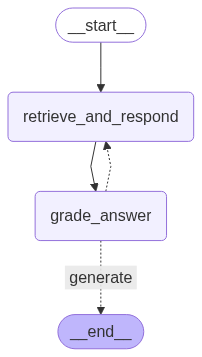

In [ ]:
# 그래프 설정
# StateGraph 객체 생성 (상태 타입으로 GraphState 사용)
builder = StateGraph(GraphState)

# 그래프에 노드(Node) 추가
# 1. retrieve_and_respond: 사용자 질문 처리 및 답변 생성 노드
builder.add_node("retrieve_and_respond", retrieve_and_respond)
# 2. grade_answer: 생성된 답변의 품질을 평가하는 노드
builder.add_node("grade_answer", grade_answer)

# 그래프의 엣지(Edge) 설정
# 시작(START) → retrieve_and_respond 노드로 연결
builder.add_edge(START, "retrieve_and_respond")
# retrieve_and_respond → grade_answer 노드로 연결
builder.add_edge("retrieve_and_respond", "grade_answer")

# 조건부 엣지 설정 (핵심 로직)
builder.add_conditional_edges(
    "grade_answer", # 출발 노드
    should_retry,   # 조건 판단 함수
    {
        # 조건에 따른 분기 설정
        "retrieve_and_respond": "retrieve_and_respond",  # 재시도 필요 시
        "generate": END   # 종료 조건 시 (END는 특수 노드)
    }
)

"""
[조건부 엣지 상세 설명]
- should_retry() 함수가 "retrieve_and_respond" 반환 시:
  → retrieve_and_respond 노드로 이동 (답변 재생성 시도)
- "generate" 반환 시:
  → END 노드로 이동 (프로세스 종료)
- generate는 실제 함수가 아닌 LangGraph의 예약된 동작으로
  "현재 결과를 최종 출력으로 사용하고 종료"를 의미
"""

# 그래프 컴파일 (실행 가능한 객체 생성)
graph = builder.compile()

# 그래프 시각화
display(Image(graph.get_graph().draw_mermaid_png()))

`(6) Graph 실행`

In [43]:
# 초기 상태
#query = "채식주의자를 위한 메뉴를 추천해주세요."
query = "해산물 메뉴를 추천해주세요."

initial_state = {
    "messages": [HumanMessage(content=query)],
}

# 그래프 실행 
final_state = graph.invoke(initial_state)

# 최종 상태 출력
print("최종 상태:\n")
pprint(final_state)

Error during grading: Error code: 400 - {'error': {'message': 'invalid schema for response format: response_format/json_schema/score: minimum is not supported', 'type': 'invalid_request_error'}}
----평가 결과 확인----
현재 점수: 0.5
생성 시도 횟수: 1
※ 점수 미달(0.7 미만) - 답변 재생성 필요
Error during grading: Error code: 400 - {'error': {'message': 'invalid schema for response format: response_format/json_schema/score: minimum is not supported', 'type': 'invalid_request_error'}}
----평가 결과 확인----
현재 점수: 0.5
생성 시도 횟수: 2
※ 점수 미달(0.7 미만) - 답변 재생성 필요
Error during grading: Error code: 400 - {'error': {'message': 'invalid schema for response format: response_format/json_schema/score: minimum is not supported', 'type': 'invalid_request_error'}}
----평가 결과 확인----
현재 점수: 0.5
생성 시도 횟수: 3
※ 최대 시도 횟수(3회) 도달 - 프로세스 종료
최종 상태:

{'documents': [Document(id='ced3778e-baff-4ea6-94c5-76eed7cec7fe', metadata={'source': './data/restaurant_menu.txt', 'menu_number': 6, 'menu_name': '해산물 파스타'}, page_content='6. 해산물 파스타\n   • 가격: ₩24,000\

In [44]:
# 최종 답변만 출력
pprint(final_state['messages'][-1].content) 

('해산물 파스타를 추천해 드립니다.\n'
 '\n'
 '가격은 24,000원이며, 알 덴테로 삶은 링귀네 파스타에 신선한 해산물을 듬뿍 올린 메뉴입니다.\n'
 '\n'
 '토마토 소스의 산미와 해산물의 감칠맛이 조화를 이루며, 마늘과 올리브 오일로 풍미를 더했습니다.\n'
 '\n'
 '파슬리를 뿌려 향긋한 맛을 더합니다.')


## 4. Gradio 챗봇

In [37]:
import gradio as gr
from typing import List, Tuple

# 예시 질문들
example_questions = [
    "채식주의자를 위한 메뉴를 추천해주세요.",
    "오늘의 스페셜 메뉴는 무엇인가요?",
    "파스타에 어울리는 음료는 무엇인가요?"
]

# 대답 함수 정의
def answer_invoke(message: str, history: List[Tuple[str, str]]) -> str:
    try:
        # 채팅 기록을 AI에게 전달할 수 있는 형식으로 변환
        chat_history = []
        for human, ai in history:
            chat_history.append(HumanMessage(content=human))
            chat_history.append(AIMessage(content=ai))

        # 기존 채팅 기록에 사용자의 메시지를 추가 (최근 2개 대화만 사용)
        initial_state = {
            "messages": chat_history[-2:]+[HumanMessage(content=message)],  
        }

        # 메시지를 처리하고 최종 상태를 반환
        final_state = graph.invoke(initial_state)
        
        # 최종 상태에서 필요한 부분 반환 (예: 추천 메뉴 등)
        return final_state["messages"][-1].content
        
    except Exception as e:
        # 오류 발생 시 사용자에게 알리고 로그 기록
        print(f"Error occurred: {str(e)}")
        return "죄송합니다. 응답을 생성하는 동안 오류가 발생했습니다. 다시 시도해 주세요."


# Gradio 인터페이스 생성
demo = gr.ChatInterface(
    fn=answer_invoke,
    title="레스토랑 메뉴 AI 어시스턴트",
    description="메뉴 정보, 추천, 음식 관련 질문에 답변해 드립니다.",
    examples=example_questions,
    theme=gr.themes.Soft()
)

# Gradio 앱 실행
demo.launch()


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


Error during grading: Error code: 400 - {'error': {'message': 'invalid schema for response format: response_format/json_schema/score: minimum is not supported', 'type': 'invalid_request_error'}}
----GRADTING---
Grade Score:  0.5
Error during grading: Error code: 400 - {'error': {'message': 'invalid schema for response format: response_format/json_schema/score: minimum is not supported', 'type': 'invalid_request_error'}}
----GRADTING---
Grade Score:  0.5
Error during grading: Error code: 400 - {'error': {'message': 'invalid schema for response format: response_format/json_schema/score: minimum is not supported', 'type': 'invalid_request_error'}}
----GRADTING---
Grade Score:  0.5
Error during grading: Error code: 400 - {'error': {'message': 'invalid schema for response format: response_format/json_schema/score: minimum is not supported', 'type': 'invalid_request_error'}}
----GRADTING---
Grade Score:  0.5
Error during grading: Error code: 400 - {'error': {'message': 'invalid schema for re

In [20]:
# 데모 종료
demo.close()

Closing server running on port: 7860
